<a href="https://colab.research.google.com/github/TuckerArrants/nlp/blob/master/textual-entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# It's Elementary, My Dear Watson

**Natural Language Inference (NLI) is a specific type of NLP task where we must determine whether or not a hypothesis is true based on a premise. Specifically, given a pair of sentences, can we classify them into three different classes: 0 - entailment, 1 - contradiction, 2 - neutral?**

**The current leading model in this field is RoBERTa, described by its creators as a 'robustly optimized BERT pretraining approach'. It changes some of the key hyperparameters of BERT and removes the next-sentece pretraining objective all together. The original paper can be found [here](https://arxiv.org/abs/1907.11692) and the source code [here](https://github.com/pytorch/fairseq/tree/master/examples/roberta)**

**Now, we have 15 different languages in our dataset, so we cannot use the standard pre-trained RoBERTa model as it has only been trained on English sequences. Luckily, there is [XLM-RoBERTa](https://huggingface.co/transformers/model_doc/xlmroberta.html) (original paper can be found [here](https://arxiv.org/abs/1911.02116)) which has been trained on 2.5TB of filtered CommonCrawl data in 100 different languages. The implementation procedude is the same as RoBERTa's, so it is easy enough to deploy. Let's see how:**

In [1]:
#python basics
from matplotlib import pyplot as plt
from tqdm import tqdm
import math, os, re, time, random
import numpy as np, pandas as pd, seaborn as sns

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#nlp augmentation
!pip install --quiet googletrans
from googletrans import Translator

#model evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold

#for fast parallel processing
from dask import bag, diagnostics

#easy way to shuffle rows
from sklearn.utils import shuffle

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Currently using Tensorflow version 2.3.0


In [2]:
#choose devicve
DEVICES = ['GPU', 'TPU']
DEVICE = DEVICES[1]

#choose number of epochs to train for
EPOCHS = 5

#choose seed
SEED = 34

#choose to see training progress or not
VERBOSE = 2

#choose maximum length of sequence inputs
MAX_LEN = 75

#choose learning rate for Adam optimizer
LR_RATE = 1e-5

#choose to generate augmented text data or not
#False if loading from external dataset, as I am
GEN_AUG = False 

#choose to add augmented text data in training
ADD_AUG = False

#choose to use external MNLI data in training
ADD_MNLI = True

#choose to use translated MNLU data in training
ADD_XMNLI = True

#choose to test on augmented datasets
USE_TTA = False

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(SEED)

# EDA

**A very brief data exploration; I will expand this section in future iterations of the notebook**

In [4]:
#get CSV files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f'Train shape: {train.shape}')
train.head()

Train shape: (12120, 6)


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [5]:
print(f'Test shape: {test.shape}')
test.head()

Test shape: (5195, 5)


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [6]:
#peek at a premise/hypothesis pair and their label
print(f"Premise: {train['premise'].values[0]}")
print(f"Hypothesis: {train['hypothesis'].values[0]}")
print(f"Label: {train['label'].values[0]}")

Premise: and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Label: 0


In [7]:
#peek at a premise/hypothesis pair and their label
print(f"Premise: {train['premise'].values[1]}")
print(f"Hypothesis: {train['hypothesis'].values[1]}")
print(f"Label: {train['label'].values[1]}")

Premise: These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Label: 2


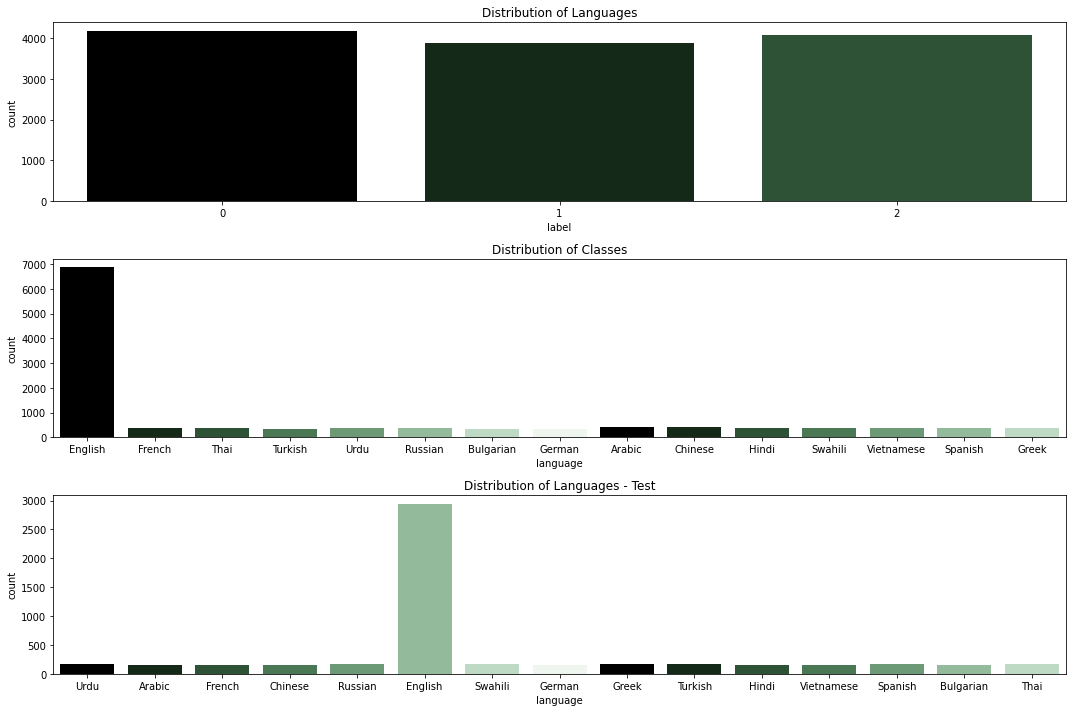

In [8]:
#explore the distribution of classes and languages
fig, ax = plt.subplots(3, figsize = (15, 10))

#for maximum aesthetics
palette = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)

graph1 = sns.countplot(train['language'], ax = ax[1], palette = palette)
graph2 = sns.countplot(train['label'], ax = ax[0], palette = palette)
graph3 = sns.countplot(test['language'], ax = ax[2], palette = palette)

#set title
graph1.set_title('Distribution of Classes')
graph2.set_title('Distribution of Languages')
graph3.set_title('Distribution of Languages - Test')

plt.tight_layout()
plt.show()

# Back-Translation

**In computer vision problems, there is a virtual infinitude of techniques you can use to augment your images ranging from simple techniques like randomly flipping images to blending images together with CutMix or MixUp. In natural language processing, it is not as easy to come up with similar augmentation strategies because it is hard to determine which transformations will preserve the meaning of the original words:**

![](https://amitness.com/images/semantic-invariance-nlp.png)

*Image from [@amitness](https://www.kaggle.com/amitness) on his excellent post on NLP augmentation [here](https://amitness.com/2020/05/data-augmentation-for-nlp/)*   


**I initially planned on using synonym swapping, where we randomly replace words with their synonyms, but then I saw [this kernel](https://www.kaggle.com/jpmiller/augmenting-data-with-translations) which is based on [this discussion thread](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/48038) and realized we can do better: we can use 'back-translation':**

![](https://amitness.com/images/backtranslation-en-fr.png)

*Image from [@amitness](https://www.kaggle.com/amitness) on his excellent post on NLP augmentation [here](https://amitness.com/2020/05/data-augmentation-for-nlp/)*

**For now, we will only translate to languages currently present in our dataset, but translating to languages outside of our dataset might give us better performance. Please note that some of these language codes are slightly different within the `googletrans` Python API. See [here](https://py-googletrans.readthedocs.io/en/latest/) for more**

In [9]:
def translation_aug(sequence, PROB = 1):
    languages = ['en', 'fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh-cn', 'hi',
                 'sw', 'vi', 'es', 'el']
    
    #instantiate translator
    translator = Translator()
    
    #store original language so we can convert back
    org_lang = translator.detect(sequence).lang
    
    #randomly choose language to translate sequence to  
    random_lang = np.random.choice([lang for lang in languages if lang is not org_lang])
    
    if org_lang in languages:
        #translate to new language and back to original
        translated = translator.translate(sequence, dest = random_lang).text
        #translate back to original language
        translated_back = translator.translate(translated, dest = org_lang).text
    
        #apply with certain probability
        #this would be used for online augmentation
        if np.random.uniform(0, 1) <= PROB:
            output_sequence = translated_back
        else:
            output_sequence = sequence
            
    #if detected language not in our list of languages, do nothing
    else:
        output_sequence = sequence
    
    return output_sequence

#check performance
for i in range(5):
    output = translation_aug('I genuinely have no idea what the output of this sequence of words will be')
    print(output)

I really have no idea what this sequence of words will be like
I really don't know what the output of this word sequence is
I really have no idea what the output of this sequence of words would be
I really don’t know what the results of this sequence of words will be
I really have no idea what the result of this sequence of words will be


**We need to decide if we want to apply this translation augmentation to the premise/hypothesis at the same time, so each sequence is mapped to the same language and back, or if we want to map them to different languages and back. It's easier to do the latter so I will experiment with it in this commit**

**This will also take a little while, so we can use `Dask Bag` to make it faster (more on Dask  [here](https://docs.dask.org/en/latest/bag.html)). Currently, it takes around 30 minutes to translate all the premise/hypothesis pairs from their original langauge, to a random language, and back again when `PROB = 1/2`**

In [10]:
def translation_aug_parallel(dataset, back = False, undersampled = True):
    prem_bag = bag.from_sequence(dataset['premise'].tolist()).map(translation_aug)
    hyp_bag =  bag.from_sequence(dataset['hypothesis'].tolist()).map(translation_aug)
    
    with diagnostics.ProgressBar():
        prems = prem_bag.compute()
        hyps = hyp_bag.compute()

    #pair premises and hypothesis
    dataset[['premise', 'hypothesis']] = list(zip(prems, hyps))
    
    return dataset

**I have already created augmented datasets with the above translation method that can be found [here](https://www.kaggle.com/tuckerarrants/contradictorywatsontranslationaug) and [here](https://www.kaggle.com/tuckerarrants/contradictorywatsontwicetranslatedaug). Let's quickly compare the three separate datasets:**

In [11]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [12]:
#offline loading of augmented datasets
train_aug = pd.read_csv('translation_aug_train.csv')
train_aug.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these ideas were considered in the develop...,The rules developed in the interim were taken ...,en,English,0
1,5b72532a0b,These are the challenges we face in practice w...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Ces petites choses font une grande différence ...,J'essaye d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,Do you know that they can't really defend them...,They cannot protect themselves because of age.,en,English,0
4,86aaa48b45,เล่นตามบทบาทด้วย โอกาสในการแสดงและเล่นบทบาทหลา...,เด็ก ๆ สามารถเห็นได้ว่าชาติพันธุ์ต่างๆมีความแต...,th,Thai,1


In [13]:
#offline loading of augmented datasets
train_twice_aug = pd.read_csv('twice_translated_aug_train.csv')
train_twice_aug.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these ideas were taken into consideration ...,Interim rules developed in conjunction with th...,en,English,0
1,5b72532a0b,These are the challenges we face in practice w...,Practice groups are not allowed to deal with t...,en,English,2
2,3931fbe82a,Ces petites choses font une grande différence ...,J'essaye d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,Do you know that they can't really defend them...,They cannot protect themselves because of age.,en,English,0
4,86aaa48b45,การเล่นบทบาทสมมติยังสามารถช่วยให้เกิดโอกาสในกา...,เด็ก ๆ สามารถเห็นโครงสร้างทางชาติพันธุ์ที่แตกต...,th,Thai,1


**Wonderful! Now you could take this dataset and apply the same procedure to generate an ever more diverse set of augmentations, or you could increase the complexity of the translation by chaining together multiple languages, i.e.**

> English -> French -> Russian -> .... -> English

**I encourage you to play around with this yourself to see what gives you the best performance**

# External Datasets

**Now, since this is not a strict competition, we can use external datasets. HuggingFace transformers makes it incredibly easy to import hundreds of thousands of NLI labeled data in minutes. If we choose to train our model with these samples, it will be much more powerful. In a real project, you would definitely just sprinkle in some of these examples until you reach your desired balance of performance/training time, so in this notebook, we will include it to see just how accurate XLM-R can get when trained on a large amount of NLI data**

### MNLI Corpus

**Here we will import additional NLI datasets, The first we can import is the [Multi-Genre NLI Corpus](https://cims.nyu.edu/~sbowman/multinli/) (MNLI). It is a crowd sourced collection of 433k sentence pairs annotated with the same labels as our dataset. We can easily import it with the new HuggingFace library `nlp`, more about this [here](https://huggingface.co/datasets/multi_nli)**

In [14]:
!pip install numpy==1.19.1

In [15]:
!pip install --quiet nlp

In [16]:
#load mnli dataset
import nlp
mnli = nlp.load_dataset("multi_nli")

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/plain_text/1.0.0/60774175381b9f3f1e6ae1028229e3cdb270d50379f45b9f2c01008f50f09e6b. Subsequent calls will reuse this data.


**Let's explore this external dataset to make sure it aligns with our needs:**

In [17]:
#check number of samples in train
mnli['train'].num_rows

392702

In [18]:
#view sample
mnli['train'][1]

{'hypothesis': 'You lose the things to the following level if the people recall.',
 'label': 0,
 'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him'}

### Adding External NLI Datasets

**Here we will add the external NLI datasets to our training dataset:**

In [19]:
#convert to a dataframe and view
mnli_df = pd.DataFrame(mnli['train'])
mnli_df = mnli_df[['premise', 'hypothesis', 'label']]
mnli_df.head(9)

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1
5,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,0
6,But a few Christian mosaics survive above the ...,Most of the Christian mosaics were destroyed b...,1
7,(Read for Slate 's take on Jackson's findings.),Slate had an opinion on Jackson's findings.,0
8,Gays and lesbians.,Heterosexuals.,2


In [20]:
#add to train
train = train[['premise', 'hypothesis', 'label']]

if ADD_MNLI:
    #add all of mnli
    #train = train.append(mnli_df)
    
    #add only every other sample from MLNI dataset
    #train = train.append(mnli_df[mnli_df.index % 2 == 0])
    
    #add only every third sample from MLNI dataset
    #train = train.append(mnli_df[mnli_df.index % 3 == 0])
    
    #add only every 10th sample from MLNI dataset
    train = train.append(mnli_df[mnli_df.index % 10 == 0])
    
    #sanity check
    print('Training size after adding external MNLI dataset:', train.shape)

Training size after adding external MNLI dataset: (51391, 3)


### Translating MNLI

**We can use `nlp` to load another dataset known as [XLNI](https://huggingface.co/datasets/xnli), but this is just a subset of MNLI that has been translated into 14 different low resource languages (undersampled), so we can produce something similar ourselves. First, let's see how to load it from `nlp`:**

In [21]:
#offline loading of XLNI
xnli = nlp.load_dataset("xnli")

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/plain_text/1.0.0/9bed2c9a464959786460b62992dcfde22ca64526ba9d9e151cd0754249266614. Subsequent calls will reuse this data.


In [22]:
#check number of samples in train
xnli['validation'].num_rows

2490

In [23]:
#view sample
xnli['validation'][1]

{'hypothesis': {'language': ['ar',
   'bg',
   'de',
   'el',
   'en',
   'es',
   'fr',
   'hi',
   'ru',
   'sw',
   'th',
   'tr',
   'ur',
   'vi',
   'zh'],
  'translation': ['لم ينطق ببنت شفة.',
   'Той не каза нито дума.',
   'Er sagte kein Wort.',
   'Δεν είπε ούτε λέξη.',
   "He didn't say a word.",
   'Él no dijo una palabra.',
   "Il n'a pas dit un mot.",
   'उसने एक शब्द नहीं कहा।',
   'Он не произнес ни слова.',
   'Hakusema chochote.',
   'เขาไม่ได้พูดสักคำ',
   'Bir kelime söylemedi.',
   'وں ا یک لفز نھی بولا',
   'Anh không nói một lời nào.',
   '他没说一句话。']},
 'label': 2,
 'premise': {'ar': 'وقال، ماما، لقد عدت للمنزل.',
  'bg': 'И той каза: Мамо, у дома съм.',
  'de': 'und er hat gesagt, Mama ich bin daheim.',
  'el': 'Και είπε, Μαμά, έφτασα στο σπίτι.',
  'en': "And he said, Mama, I'm home.",
  'es': 'Y él dijo: Mamá, estoy en casa.',
  'fr': 'Et il a dit, maman, je suis à la maison.',
  'hi': 'और उसने कहा, माँ, मैं घर आया हूं।',
  'ru': 'И он сказал: Мама, я дома.',


**We can manually create an XNLI dataset if we translate a small set of premise/hypothesis pairs from MNLI to under sampled languages in our dataset. This gives us the ability to oversample certain languages, countering against language imbalances in our training dataset. The below code randomly translates 1500 MNLI samples to Urdu and another 1500 samples to Swahili**

In [24]:
#instantiate translator
translator = Translator()
    
#select small set of MNLI to translate
mnli_sample = mnli_df[mnli_df.index % 100 == 0]

#shuffle sample
mnli_sample = shuffle(mnli_sample)

if ADD_XMNLI:
    print('Training size before adding external XMNLI dataset:', train.shape)
    #translate half to Urdu
    print('Translating to Urdu...'); print('')
    mnli_sample[:len(mnli_sample)//2]['premise'].apply(lambda prem: translator.translate(prem, dest = 'ur').text)
    mnli_sample[:len(mnli_sample)//2]['hypothesis'].apply(lambda prem: translator.translate(prem, dest = 'ur').text)

    #translate half to Swahili
    print('Translating to Swahili...');print('')
    mnli_sample[len(mnli_sample)//2:]['premise'].apply(lambda prem: translator.translate(prem, dest = 'sw').text)
    mnli_sample[len(mnli_sample)//2:]['hypothesis'].apply(lambda prem: translator.translate(prem, dest = 'sw').text)
    
    #add to training dataset
    train = train.append(mnli_sample)
    
    #sanity check
    print('Training size after adding external XMNLI dataset:', train.shape)

Training size before adding external XMNLI dataset: (51391, 3)
Translating to Urdu...

Translating to Swahili...

Training size after adding external XMNLI dataset: (55319, 3)


# Configure TPU

**Now we have to make some TPU-training specific changes. First, we must connect to and initialize our TPU:**

In [25]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
#REPLICAS = 8
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.100.79.50:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.100.79.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.79.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [26]:
#choose batch size - will depend on cores of our device
BATCH_SIZE = 32 * REPLICAS

# Getting Datasets

**HuggingFace Transformers makes it unbelievable easy to use transformers. In fact, you don't even need to specify the transformer or tokenizer: its architecture can be guessed from the name or path of the pretrained model you specify in the `from_pretrained` method. To read more about AutoModels/Tokenizers, see [this](https://huggingface.co/transformers/model_doc/auto.html)**

In [27]:
#get HuggingFace transformers
!pip install --quiet transformers

#import model and Tokenizer
from transformers import TFAutoModel, AutoTokenizer

#get paths to TensorFlow XLM-RoBERTa base and large models
roberta_base = "jplu/tf-xlm-roberta-base"
roberta_large = 'jplu/tf-xlm-roberta-large'

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 3.0MB 9.9MB/s 
     |████████████████████████████████| 1.1MB 37.8MB/s 
     |████████████████████████████████| 890kB 25.5MB/s 


## Augmented Datasets

**We can start by creating a simple train/validation split here and then converting them to `tf.data.Dataset` format which is the format we need to put our datasets into before we send them to the TPUs. For more about buidling data pipelines in TensorFlow, see [here](https://www.tensorflow.org/guide/data):**

**Now, we do not want any samples in our validation set used to create the augmented dataset, or we will overfit our validation data. So you can either split your data into train and validation first and then augment only on train, or you can import the offline dataset and manually remove the validation indices from it and add that to the original training data**

In [28]:
#get train, val splits
train, val, train_labels, val_labels = train_test_split(train, train['label'],
                                                        test_size = 0.2,
                                                        random_state = SEED)

#check size before augmenting
print(f'Training size before translation augmentation: {len(train)}')

if GEN_AUG:
    #now we generate augmented data
    train_aug = train.copy().pipe(translation_aug_parallel)

if ADD_AUG:
    #remove validation indexs samples from our augmented dataset
    train_aug = train_aug.drop(val.index)
    train_twice_aug = train_twice_aug.drop(val.index)

    #and shuffle
    train_aug = shuffle(train_aug)
    train_twice_aug = shuffle(train_twice_aug)

    #add only twice augmented dataset to existing training dataset
    train = train.append(train_twice_aug)
    train_labels = train_labels.append(train_twice_aug['label'])

    #add both external datasets to existing training dataset
    #train = train.append([train_aug, train_twice_aug])
    #train_labels = train_labels.append([train_aug['label'], train_twice_aug['label']])

Training size before translation augmentation: 44255


In [29]:
#check size after augmenting
print(f'Training size after translation augmentation: {len(train)}')

Training size after translation augmentation: 44255


In [30]:
#create tokenzer object
TOKENIZER = AutoTokenizer.from_pretrained(roberta_large)

#define inputs to give our tokenizer (and training labels)
train_text = train[['premise', 'hypothesis']].values.tolist()
val_text = val[['premise', 'hypothesis']].values.tolist()
test_text = test[['premise', 'hypothesis']].values.tolist()

#tokenize our text here
#will functionize these later
print('Encoding train...')
train_enc = TOKENIZER.batch_encode_plus(
    train_text,
    pad_to_max_length = True,
    max_length = MAX_LEN
)
print('')

print('Encoding validation...')
val_enc = TOKENIZER.batch_encode_plus(
    val_text,
    pad_to_max_length = True,
    max_length = MAX_LEN
)
print('')

print('Encoding test...')
test_enc = TOKENIZER.batch_encode_plus(
    test_text,
    pad_to_max_length = True,
    max_length = MAX_LEN
)
print('')
print('Done')

Encoding train...



Encoding validation...



Encoding test...

Done


In [31]:
#convert train dataset to tf.data.Dataset format
print('Converting train dataset to TPU format...')
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_enc['input_ids'], train_labels))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
print('')

#convert validation dataset to tf.data.Dataset format
print('Converting validation dataset to TPU format...')
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((val_enc['input_ids'], val_labels))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
print('')

#convert test dataset to tf.data.Dataset format
print('Converting test dataset to TPU format...')
test_ds = (
    tf.data.Dataset
    .from_tensor_slices(test_enc['input_ids'])
    .batch(BATCH_SIZE)
)
print('')
print('Done')

Converting train dataset to TPU format...

Converting validation dataset to TPU format...

Converting test dataset to TPU format...

Done


# Learning Rate Schedule

**It is generally a good idea to use a learning rate scheduler when transfer learning. Our pretrained model already knows quite a bit, so we want to start the learning rate at 0: if we start with a high learning rate, there is a chance we 'erase' the weights that the model already had, defeating the purpose of transfer learning. We then slowly increase the learning rate as the model adapts to the new data:** 

**Note that I am still figuring out the best learning rate schedule as the current one does not seem to provide much increase in score/smoother training**

Learning rate schedule for step schedule: 1e-06 to 8e-06 to 8e-06
Learning rate schedule for smooth schedule: 1e-06 to 8e-06 to 6.6e-06


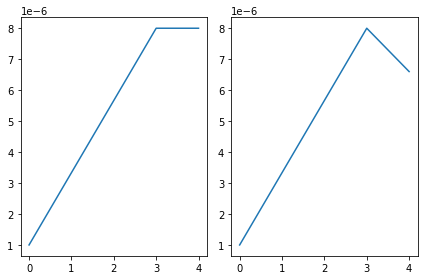

In [32]:
#define learning rate parameters
LR_START = 1e-6
LR_MAX = 1e-6 * REPLICAS
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#stepwise schedule
def lrfn_step(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
    return lr


#smoothish schedule
def lrfn_smooth(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback_step = tf.keras.callbacks.LearningRateScheduler(lrfn_step, verbose = True)
lr_callback_smooth = tf.keras.callbacks.LearningRateScheduler(lrfn_smooth, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y1 = [lrfn_step(x) for x in rng]
y2 = [lrfn_smooth(x) for x in rng]
fix, ax = plt.subplots(1,2)
ax[0].plot(rng, y1)
ax[1].plot(rng, y2)
plt.tight_layout()
print("Learning rate schedule for step schedule: {:.3g} to {:.3g} to {:.3g}".format(y1[0], max(y1), y1[-1]))
print("Learning rate schedule for smooth schedule: {:.3g} to {:.3g} to {:.3g}".format(y2[0], max(y2), y2[-1]))

# Model Training

**We can use the `mish` activation here which is a non-monotonic activation function that tends to work better than `relu`. You can read more about it [here](https://arxiv.org/abs/1908.08681#:~:text=Mish%3A%20A%20Self%20Regularized%20Non%2DMonotonic%20Neural%20Activation%20Function,-Diganta%20Misra&text=In%20this%20work%2C%20a%20novel,deep%20networks%20across%20challenging%20datasets). Sadly, it is not a predefined activation function in `tf.keras` so we need to construct it ourselves, which is easy to do**

**Here is a quick graphic that shows the differences between the most popular activation functions:**

![](https://raw.githubusercontent.com/krutikabapat/krutikabapat.github.io/master/assets/activation.png)

*Image taken from [here](https://krutikabapat.github.io/Swish-Vs-Mish-Latest-Activation-Functions/)*

In [33]:
from tensorflow.math import softplus, tanh
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Dense, Input, Activation, Dropout

# softplus - log(exp(x)+1)
def mish(x):
    return x*tanh(softplus(x))

#create misch activation to use in tf.keras
get_custom_objects()["mish"] = Activation(mish)

In [34]:
#helper function to create our model
def build_model(transformer_layer, learning_rate = LR_RATE):
    #must use this to send to TPU cores
    with strategy.scope():
        #define input(s)
        input_ids = tf.keras.Input(shape = (MAX_LEN,), dtype = tf.int32)
        
        #insert roberta layer
        roberta = TFAutoModel.from_pretrained(transformer_layer)
        roberta = roberta(input_ids)[0]
        
        #only need <s> token here, so we extract it now
        out = roberta[:, 0, :]
        
        #add optional Dense layer with dropout
        #out = tf.keras.layers.Dropout(.2)(out)
        
        #two layers with mish activation
        #out = tf.keras.layers.Dense(MAX_LEN // 2, activation='mish')(out)
        #out = tf.keras.layers.Dense(MAX_LEN // 4, activation='mish')(out)
        
        #two layers with relu activation
        #out = tf.keras.layers.Dense(32, activation = 'relu')(out)
        #out = tf.keras.layers.Dense(16, activation = 'relu')(out)
        
        #add our softmax layer
        out = tf.keras.layers.Dense(3, activation = 'softmax')(out)
        
        #assemble model and compile
        model = tf.keras.Model(inputs = input_ids, outputs = out)
        model.compile(
                        optimizer = tf.keras.optimizers.Adam(lr = LR_RATE), 
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])
        
    return model  

**Some people don't believe in saving the best model and loading it after training. For one, it takes up extra space, especially if your model has hundreds of millions of parameters. In fact, you can only save 3 copies of RoBERTa-large to Kaggle memory before you run out of space**

**Secondly, your training should be stable, so setting your training to a fixed number of epochs should produce similar results as using a `val_loss` monitor. If you are worried that training your model for one or two more epochs will completely throw your weights off, then you haven't found good weights for your model (for smaller models where you can easily regularize your model to train for longer periods of time). That being said, RoBERTa is a large model that can quickly overfit a dataset in a single epoch, so we will use a `val_loss` checkpoint callback:**

In [36]:
#choose to see training
#0 for nothing, 1 for progress bar, 2 for each epoch
VERBOSE = 2

#to clear the TPU memory
print('---' *20)
print(f"Getting model...")
if DEVICE == 'TPU':
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
#get steps per epoch values
STEPS_PER_EPOCH = len(train) // BATCH_SIZE

#make callback to save best model from training
save_callback = tf.keras.callbacks.ModelCheckpoint(f"best_model.h5", monitor = 'val_loss', verbose = 0,
                        save_best_only = True, save_weights_only = True, mode = 'min')

#build and make save callback
RoBERTa = build_model(roberta_base)
print(f"Training with batch size {BATCH_SIZE}")

#and train
history = RoBERTa.fit(train_ds, steps_per_epoch = STEPS_PER_EPOCH,
                      #validation_split = .2, 
                      validation_data = val_ds,
                      epochs = EPOCHS, verbose = VERBOSE,
                      callbacks = [save_callback],
                      #callbacks = [save_callback, lr_callback_smooth]
                      )

------------------------------------------------------------
Getting model...


INFO:tensorflow:Initializing the TPU system: grpc://10.100.79.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.79.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training with batch size 256
Epoch 1/5


172/172 - 98s - loss: 1.1085 - accuracy: 0.3489 - val_loss: 1.1015 - val_accuracy: 0.3437
Epoch 2/5
172/172 - 46s - loss: 1.0908 - accuracy: 0.3720 - val_loss: 1.0849 - val_accuracy: 0.3642
Epoch 3/5
172/172 - 46s - loss: 1.0212 - accuracy: 0.4650 - val_loss: 0.8627 - val_accuracy: 0.6098
Epoch 4/5
172/172 - 49s - loss: 0.7887 - accuracy: 0.6613 - val_loss: 0.6793 - val_accuracy: 0.7194
Epoch 5/5
172/172 - 49s - loss: 0.6682 - accuracy: 0.7212 - val_loss: 0.6324 - val_accuracy: 0.7474


**Once the model's weights have been saved to the disk, we can easily load them into an untrained model. This means we only need to train once and then we can store the weights in another notebook with other model weights to easily compare the performance of different models**

In [37]:
#load best model
print('Loading best model...')
RoBERTa.load_weights(f"best_model.h5")
print('Best model loaded')

Loading best model...
Best model loaded


# Test Time Augmentation

**Here we will experiment with test time augmentation by predicting on our 3 separate test datasets and then averaging the results. This is standard practice in computer vision so I want to test it in NLP to see how it performs:**

In [38]:
#get external augmented test sets
test_aug = pd.read_csv('translation_aug_test.csv')
test_twice_aug = pd.read_csv('twice_translated_aug_test.csv')

#compare different datasets
print(test.shape)
test.head()

(5195, 5)


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [39]:
#view augmented
print(test_aug.shape)
test_aug.head()

(5195, 5)


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,باکسز کا نام باکس ، کیسی ، راچیل ، یسعیاہ ، کی...,کولمین ہائی اسکول کے ایک طالب علم کیسی کو کوئی...,ur,Urdu
1,cefcc82292,هذا نصح لنا.,عندما يتم إخبارنا بما يجب القيام به ، لا تسمح ...,ar,Arabic
2,e98005252c,Et la raison la plus probable est due au fait ...,La mère se drogue.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, но она осталась.",ru,Russian


In [40]:
#view twice augmented
print(test_twice_aug.shape)
test_twice_aug.head()

(5195, 5)


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,باکسز کا نام باکس ، کیسی ، راچیل ، یسعیاہ ، کی...,کولمین ہائی اسکول کے ایک طالب علم کیسی کو کوئی...,ur,Urdu
1,cefcc82292,تم نصح هذا لنا.,عندما يتم إخبارنا بما يجب القيام به ، لا تسمح ...,ar,Arabic
2,e98005252c,Et la raison possible est que la mère prend le...,Mère prend de la drogue.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, вы уезжаете, но он остался.",ru,Russian


In [41]:
#select relevant columns
test_aug_text = test_aug[['premise', 'hypothesis']].values.tolist()
test_twice_aug_text = test_twice_aug[['premise', 'hypothesis']].values.tolist()

if USE_TTA:
    #encode 
    print('Encoding test dataset(s)...')
    test_aug_enc = TOKENIZER.batch_encode_plus(
        test_aug_text,
        pad_to_max_length = True,
        max_length = MAX_LEN
    )

    #encode
    test_twice_aug_enc = TOKENIZER.batch_encode_plus(
        test_twice_aug_text,
        pad_to_max_length = True,
        max_length = MAX_LEN
    )

    #convert to TPU format
    test_aug_ds = (
        tf.data.Dataset
        .from_tensor_slices(test_aug_enc['input_ids'])
    .batch(BATCH_SIZE)
    )

    #convert to TPU format
    test_twice_aug_ds = (
        tf.data.Dataset
        .from_tensor_slices(test_twice_aug_enc['input_ids'])
    .batch(BATCH_SIZE)
    )
    print('')
    print('Done')

In [42]:
#finally, get all predictions
preds = RoBERTa.predict(test_ds)

if USE_TTA:
    preds_aug = RoBERTa.predict(test_aug_ds)
    preds_twice_aug = RoBERTa.predict(test_twice_aug_ds)

    #and blend predictions equally
    blended_preds = (preds + preds_aug + preds_twice_aug)/3

In [47]:
#create submission dataframe and save
submission = pd.DataFrame()
submission['id'] = test['id']

if USE_TTA:
    #choose blended predictions as final predictions
    submission['prediction'] = blended_preds.argmax(axis = 1)

else:
    #choose predictions on reg test set as final predictions
    submission['prediction'] = preds.argmax(axis = 1)

#sanity check
submission.head(10)

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2
5,aa2510d454,0
6,865d1c7b16,1
7,a16f7ed56b,0
8,6d9fa191e6,1
9,c156e8fed5,2


In [48]:
submission.to_csv('submission.csv', index = False)
print('Submission saved')

Submission saved


**As this is a new getting started competition, this notebook is a work in progress that I will continually update as the competition grows. If you have any questions/suggestions, please leave them below. Stay tuned for more!**